# Detecting Anomalous Credit Card Transactions

This project aims to detect fraud in credit card transactions via anomaly detection.

## Data

The dataset I will use consists of 284 807 credit card transactions with 492 labeled as fraud (`Class` `1`). Only 0.172 % of all transactions are fraud.  

Most features (`V1`, `V2`, ..., `V27`) were identified via Principal Component Analysis (PCA). The only retained original features are `Time` & `Amount`.



In [151]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest

warnings.filterwarnings('ignore')

df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

# remove NaN and inf values
df = df.dropna()
df = df.replace([-np.inf, np.inf], np.nan)

df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


### Data Understanding

Further, we will utilize Exploratory Data Analysis (EDA) to get more insights into the data.

#### Correlation analysis

We start with some analysis to identify correlations between features:

<Axes: >

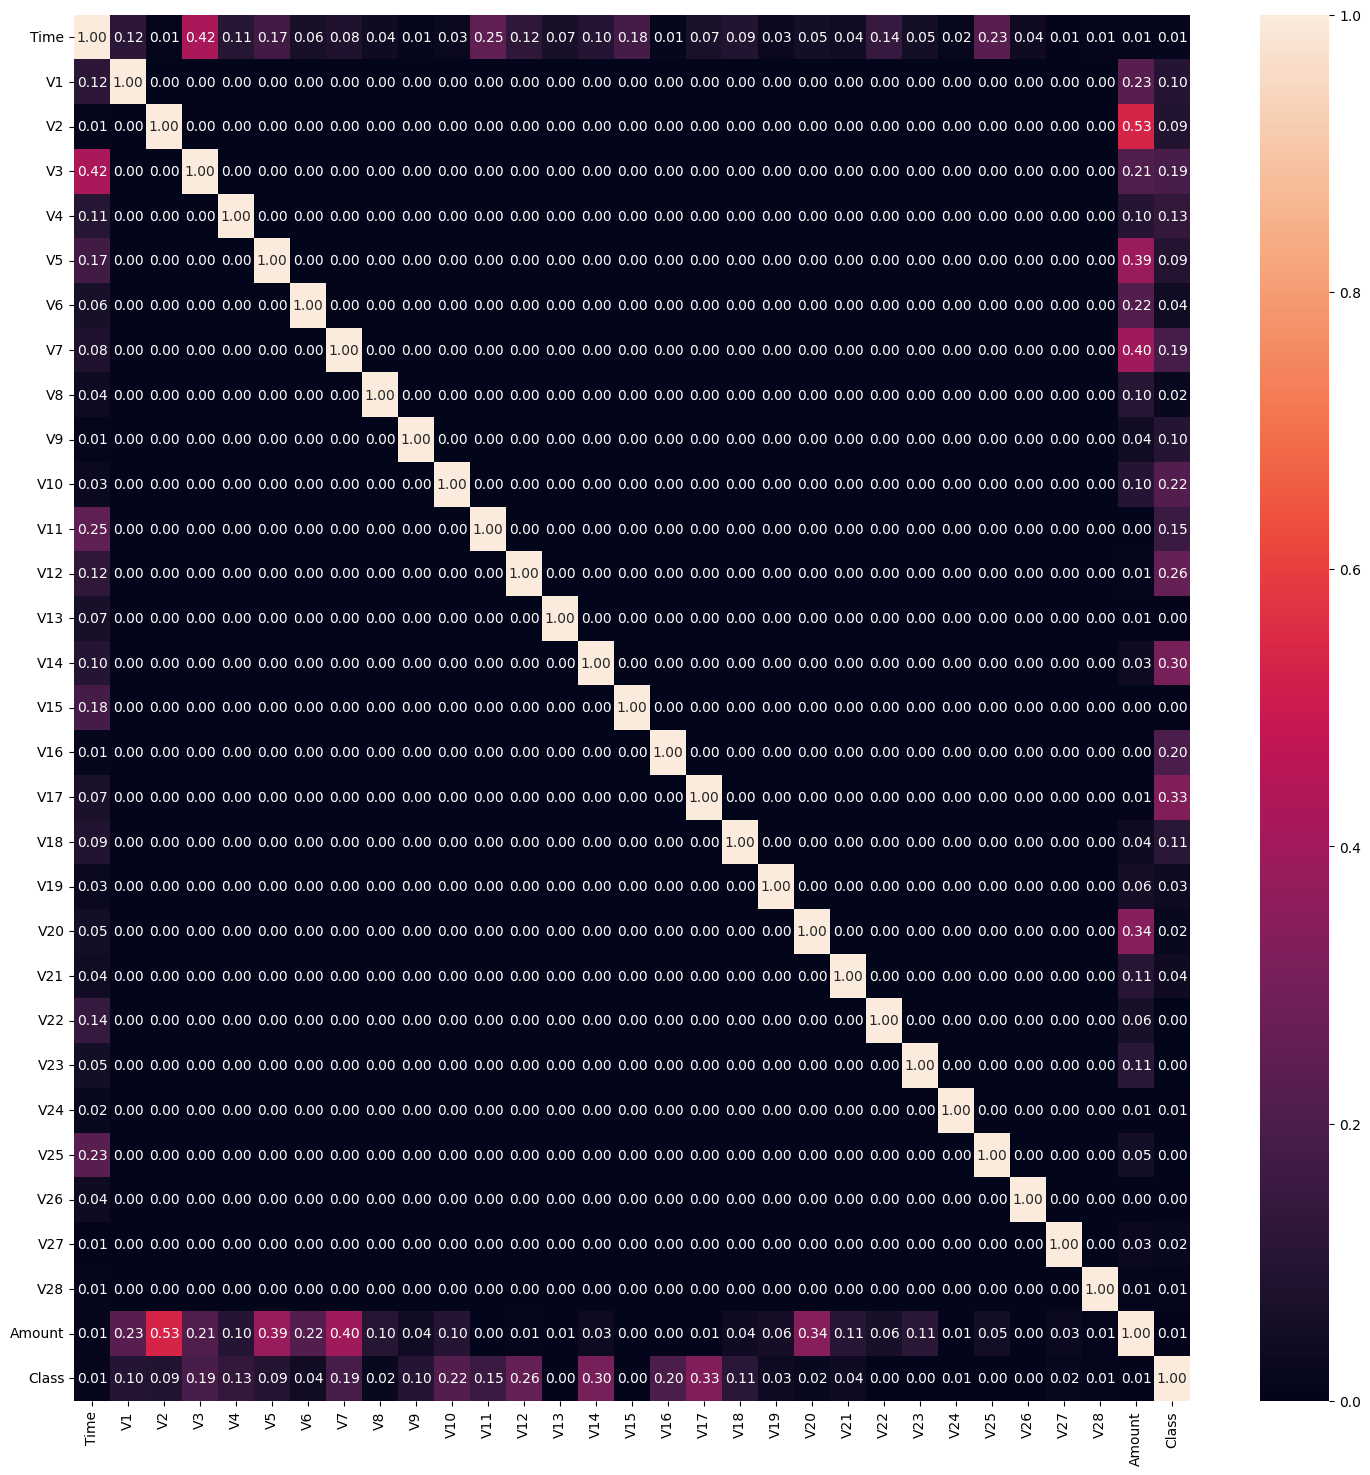

In [152]:
corr_matrix = df.corr(numeric_only=True).abs()

plt.figure(figsize=(18, 18))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cbar=True)

Let's look at the distribution of the transactions over time & the amounts:

Text(0, 0.5, 'Frequency')

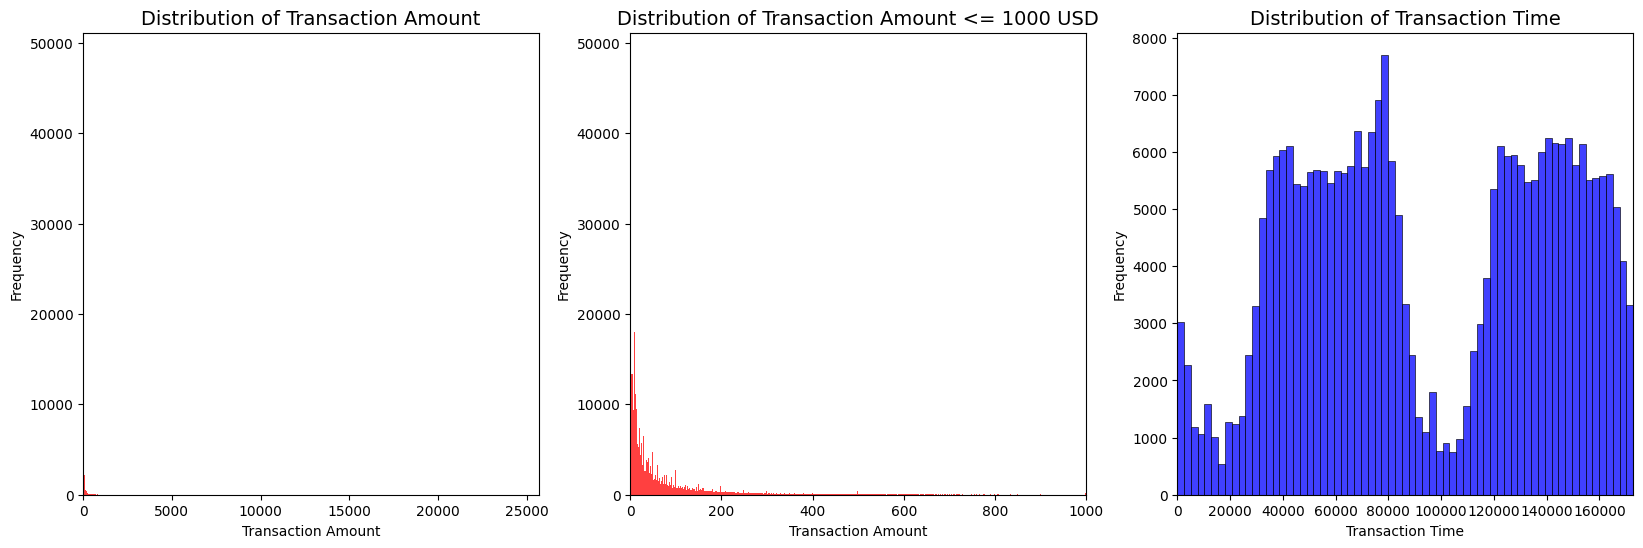

In [153]:
fig, ax = plt.subplots(1, 3, figsize=(20,6))

amount = df["Amount"].values
time = df["Time"].values

sns.histplot(amount, ax=ax[0], color="r")
ax[0].set_xlim([min(amount), max(amount)])
ax[0].set_title("Distribution of Transaction Amount", fontsize=14)
ax[0].set_xlabel("Transaction Amount")
ax[0].set_ylabel("Frequency")

sns.histplot(amount, ax=ax[1], color="r")
ax[1].set_xlim([min(amount), 1000])
ax[1].set_title("Distribution of Transaction Amount <= 1000 USD", fontsize=14)
ax[1].set_xlabel("Transaction Amount")
ax[1].set_ylabel("Frequency")

sns.histplot(time, ax=ax[2], color="b")
ax[2].set_xlim([min(time), max(time)])
ax[2].set_title("Distribution of Transaction Time", fontsize=14)
ax[2].set_xlabel("Transaction Time")
ax[2].set_ylabel("Frequency")

We see that smaller transaction amounts are generally much more frequent and we see that the amount of transactions over time follows a pattern.

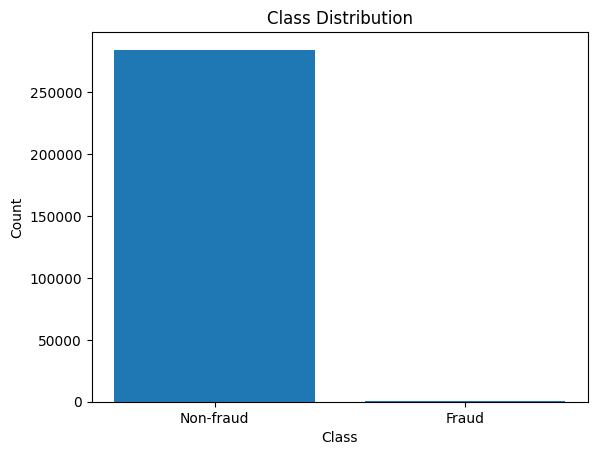

In [154]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_class_distribution(y):
    count_class = y.value_counts()
    plt.bar(count_class.index, count_class.values)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Class Distribution')
    plt.xticks(count_class.index, ['Non-fraud', 'Fraud'])
    plt.show()

plot_class_distribution(df['Class'])

## Data pre-processing

In [155]:
# dropping all values with correlation lower than 0.15
corr = corr_matrix[['Class']]
drop = list(corr[corr['Class'] < 0.15].index)
print("dropping columns:", drop)

df.drop(drop, axis=1, inplace=True)
df

dropping columns: ['Time', 'V1', 'V2', 'V4', 'V5', 'V6', 'V8', 'V9', 'V13', 'V15', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


,V3,V7,V10,V11,V12,V14,V16,V17,Class
0,2.536347,0.239599,0.090794,-0.551600,-0.617801,-0.311169,-0.470401,0.207971,0
1,0.166480,-0.078803,-0.166974,1.612727,1.065235,-0.143772,0.463917,-0.114805,0
2,1.773209,0.791461,0.207643,0.624501,0.066084,-0.165946,-2.890083,1.109969,0
3,1.792993,0.237609,-0.054952,-0.226487,0.178228,-0.287924,-1.059647,-0.684093,0
4,1.548718,0.592941,0.753074,-0.822843,0.538196,-1.119670,-0.451449,-0.237033,0
...,...,...,...,...,...,...,...,...,...
284802,-9.834783,-4.918215,4.356170,-1.593105,2.711941,4.626942,1.107641,1.991691,0
284803,2.035030,0.024330,-0.975926,-0.150189,0.915802,-0.675143,-0.711757,-0.025693,0
284804,-3.249640,-0.296827,-0.484782,0.411614,0.063119,-0.510602,0.140716,0.313502,0
284805,0.702510,-0.686180,-0.399126,-1.933849,-0.962886,0.449624,-0.608577,0.509928,0


In [156]:
print("remaining columns:", df.columns)

remaining columns: Index(['V3', 'V7', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'Class'], dtype='object')


For the remaining features we take a look at the pairplot:

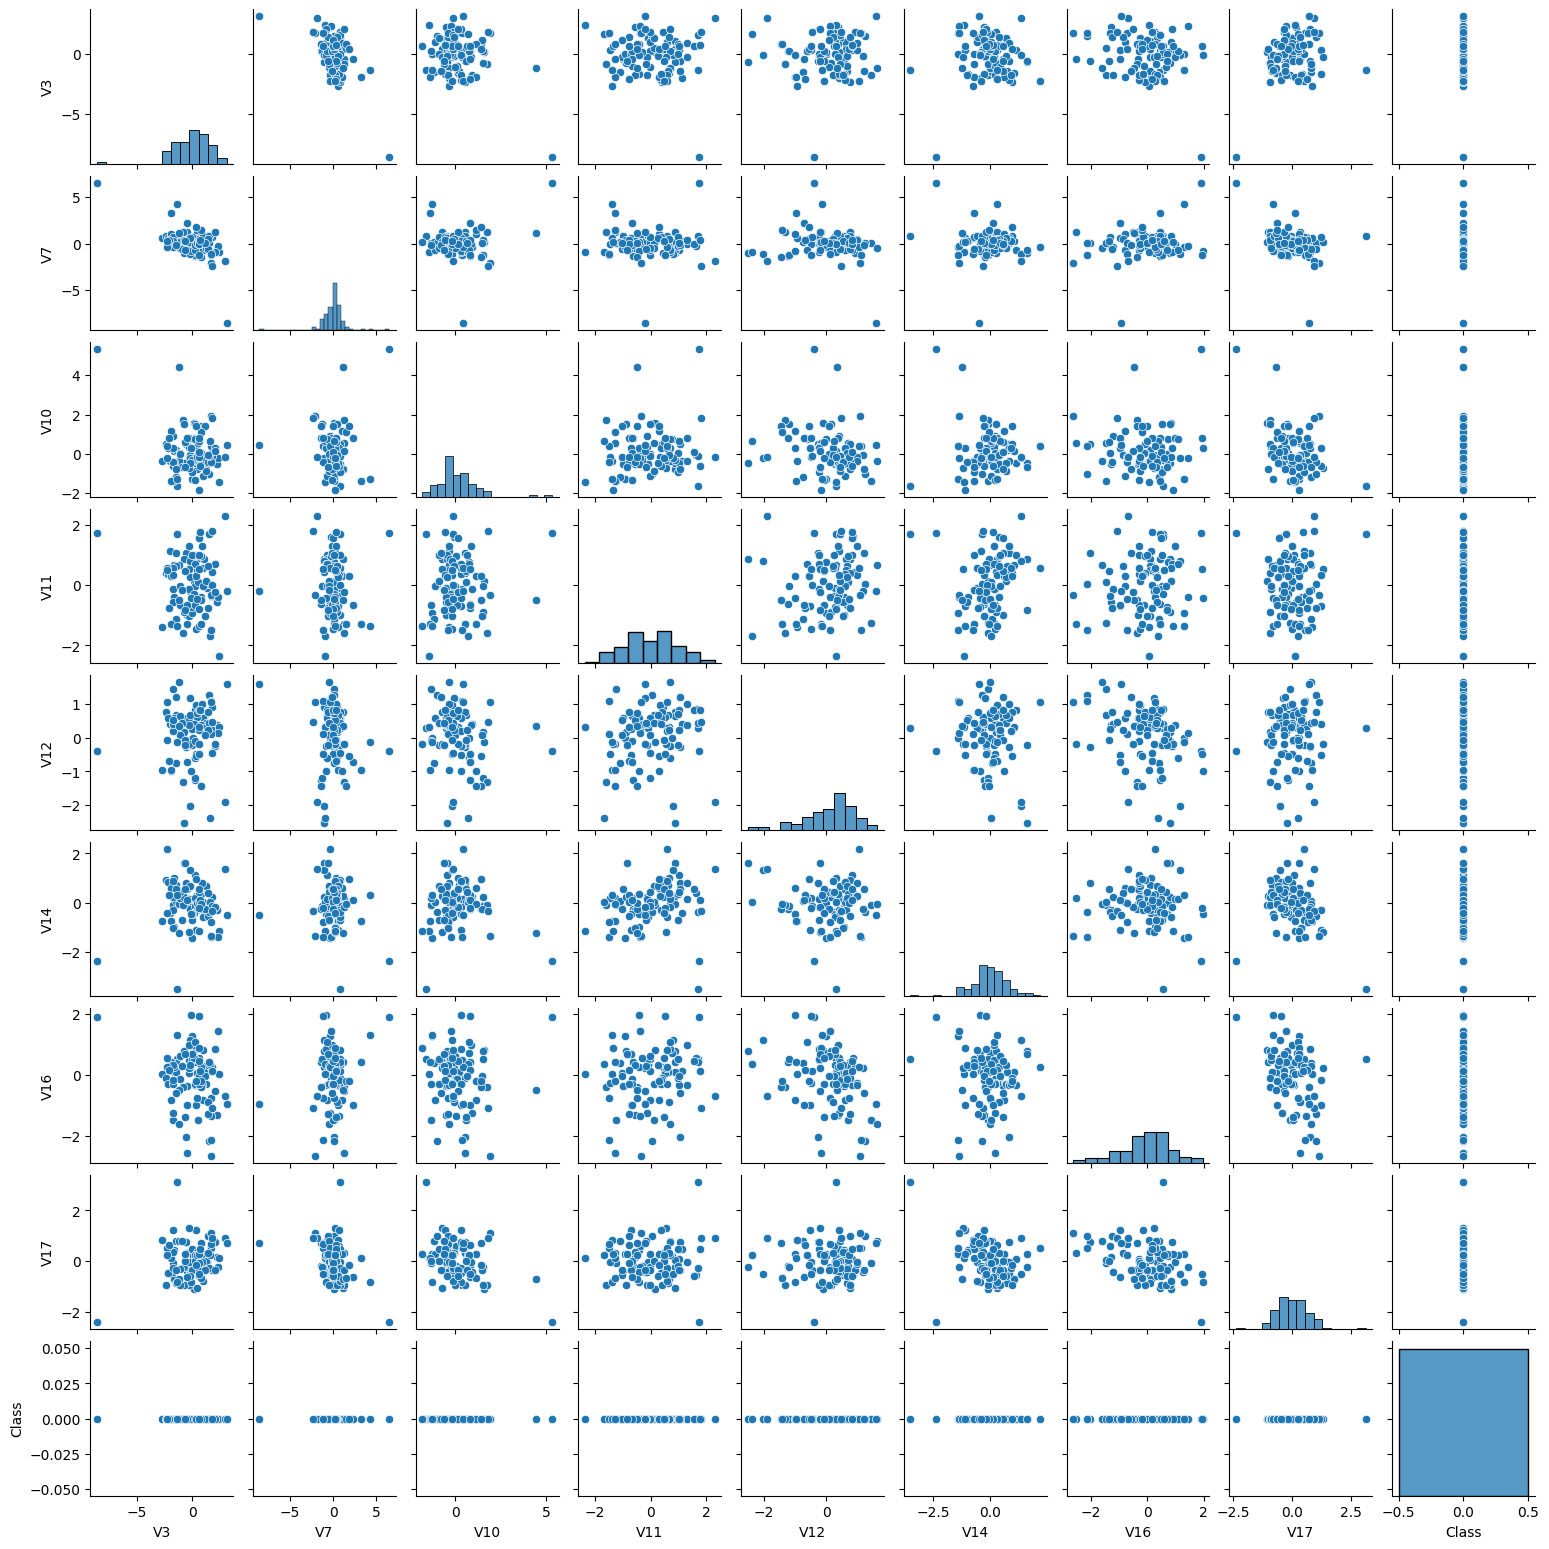

In [157]:
sns.pairplot(df.sample(100), height=1.75)

## Data modelling

First, I split the data into a training (35 %), validation (35 %), and test set (30 %) to be able to validate the model performance later.

Due to the the large imbalance of fraud vs non-fraud transactions, we will use a stratified split to make sure test and training data retain the same proportion of fraud and non-fraud transactions.

In [158]:
y = df['Class']
X = df.drop('Class', axis=1)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

Next we define a few reusable functions for evaluating model performance including a few visualisations:

In [159]:
from sklearn.metrics import f1_score, matthews_corrcoef, classification_report, confusion_matrix, roc_curve, auc, roc_curve, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

def plot_confusion_matrix(y_test, y_pred):
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(8,6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def evaluate(model, X_test, y_test, y_pred):
    # Matthews Correlation Coefficient (MCC)
    mcc = matthews_corrcoef(y_test, y_pred)
    print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")

    # Classification Report: Precision, Recall, F1, Support
    class_report = classification_report(y_test, y_pred)
    print(class_report)

    plot_confusion_matrix(y_test, y_pred)

## Unsupervised Learning

Our goal is to create a model that can detect credit card fraud well on unlabeled data, thus even though the dataset includes labels for fraud, I will utilize unsupervised learning models.

I will evaluate the following methods:
- Local Outlier Factor
- Isolation Forest

### Local Outlier Factor

Matthews Correlation Coefficient (MCC): 0.5323
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42648
           1       0.35      0.81      0.49        74

    accuracy                           1.00     42722
   macro avg       0.68      0.90      0.74     42722
weighted avg       1.00      1.00      1.00     42722



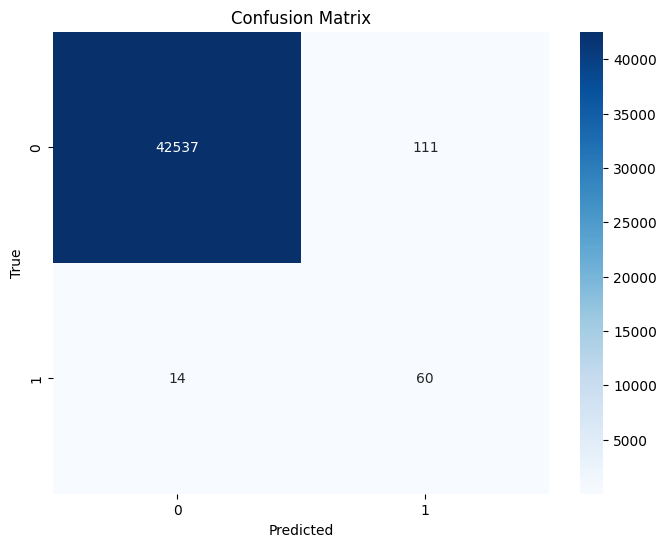

Matthews Correlation Coefficient (MCC): 0.5234
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42647
           1       0.35      0.80      0.48        74

    accuracy                           1.00     42721
   macro avg       0.67      0.90      0.74     42721
weighted avg       1.00      1.00      1.00     42721



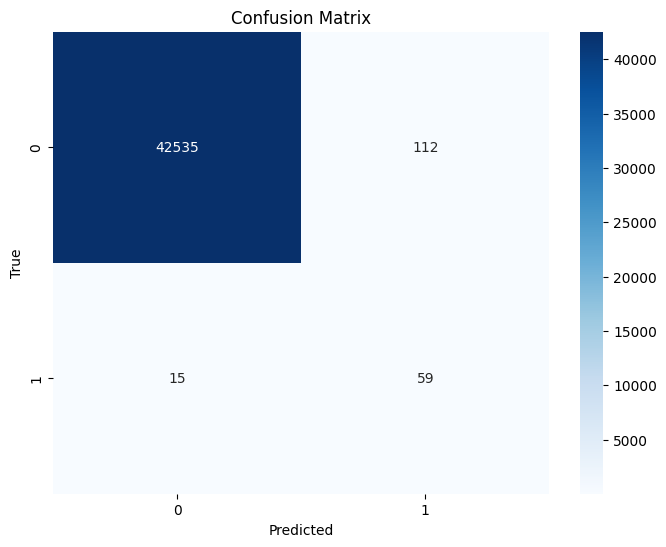

In [177]:
from sklearn.neighbors import LocalOutlierFactor

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly_features', PolynomialFeatures()),
    ('local_outlier', LocalOutlierFactor(n_neighbors=70, contamination=0.004))
])

y_pred = pipeline.fit_predict(X_test)
y_pred = [1 if y == -1 else 0 for y in y_pred]
evaluate(pipeline, X_test, y_test, y_pred)

y_pred = pipeline.fit_predict(X_val)
y_pred = [1 if y == -1 else 0 for y in y_pred]
evaluate(pipeline, X_val, y_val, y_pred)

### Isolation Forest

Matthews Correlation Coefficient (MCC): 0.4675
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42648
           1       0.28      0.80      0.41        74

    accuracy                           1.00     42722
   macro avg       0.64      0.90      0.70     42722
weighted avg       1.00      1.00      1.00     42722



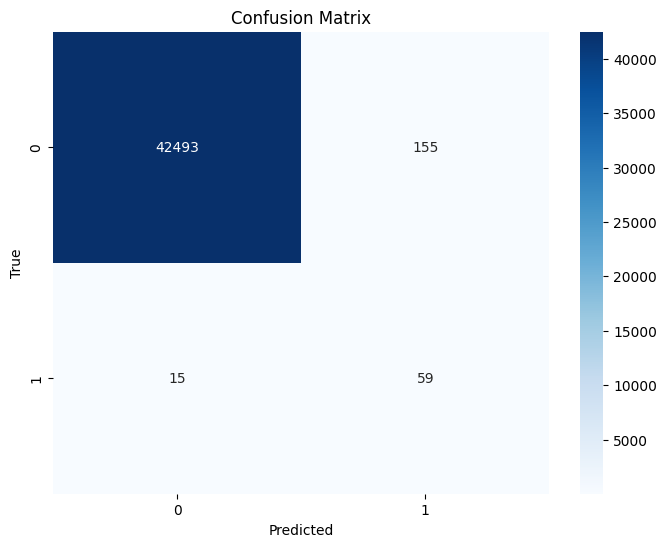

Matthews Correlation Coefficient (MCC): 0.4515
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42647
           1       0.27      0.77      0.40        74

    accuracy                           1.00     42721
   macro avg       0.63      0.88      0.70     42721
weighted avg       1.00      1.00      1.00     42721



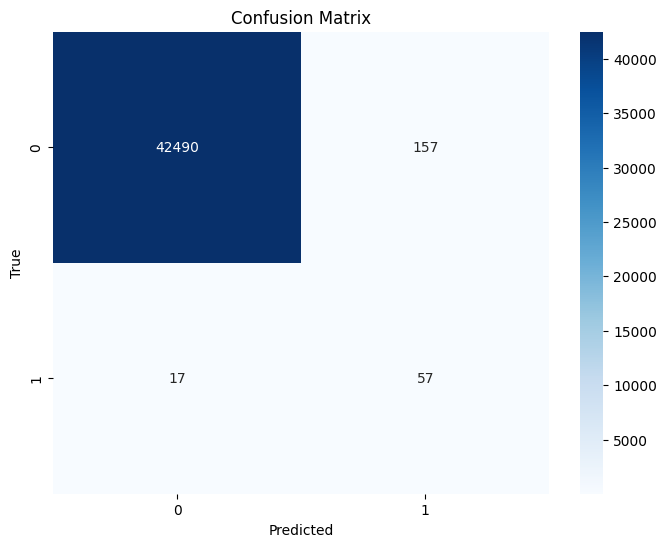

In [182]:
from sklearn.ensemble import IsolationForest

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly_features', PolynomialFeatures()),
    ('isolation_forest', IsolationForest(n_estimators=125, contamination=0.005, random_state=42))
])

y_pred = pipeline.fit_predict(X_test)
y_pred = [1 if y == -1 else 0 for y in y_pred]
evaluate(pipeline, X_test, y_test, y_pred)

y_pred = pipeline.fit_predict(X_val)
y_pred = [1 if y == -1 else 0 for y in y_pred]
evaluate(pipeline, X_val, y_val, y_pred)

## Supervised Learning (for comparison)

Since we have training data that is already labeled as either fraud or not, I also include a few supervised learning model for comparison:
- Polynomial Logistic Regression
- Decision Tree
- Support Vector Machine (SVM)

### Polynomial Logistic Regression

Matthews Correlation Coefficient (MCC): 0.8280
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42648
           1       0.89      0.77      0.83        74

    accuracy                           1.00     42722
   macro avg       0.95      0.89      0.91     42722
weighted avg       1.00      1.00      1.00     42722



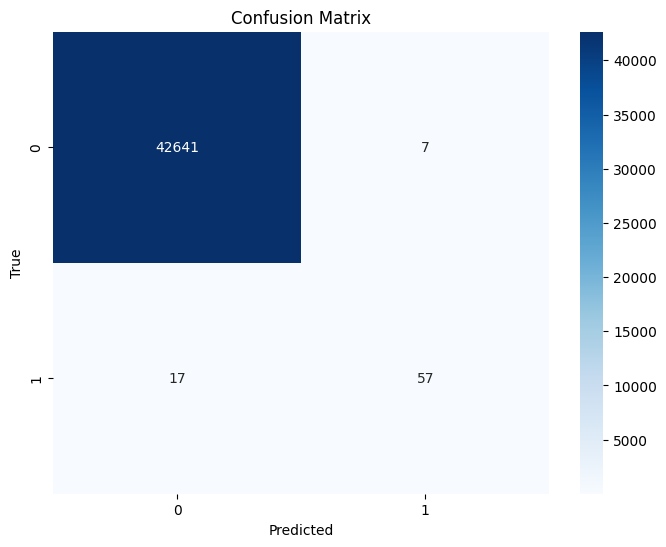

Matthews Correlation Coefficient (MCC): 0.7805
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42647
           1       0.79      0.77      0.78        74

    accuracy                           1.00     42721
   macro avg       0.90      0.88      0.89     42721
weighted avg       1.00      1.00      1.00     42721



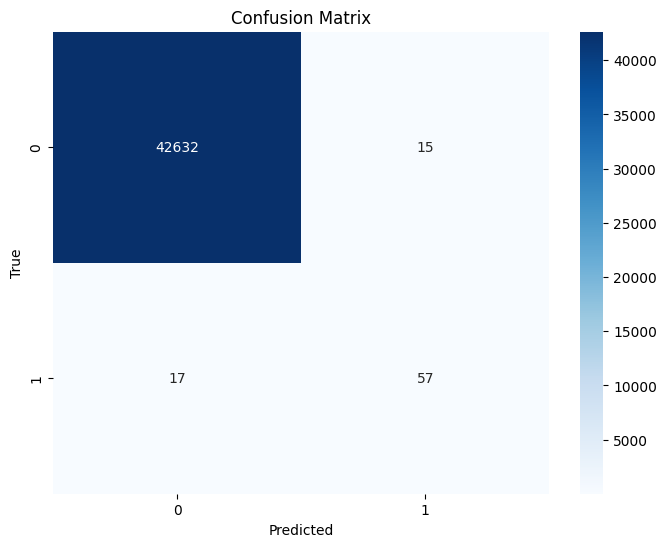

In [178]:
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly_features', PolynomialFeatures()),
    ('logistic_regression', LogisticRegression(solver='newton-cholesky', class_weight={0: 0.3, 1: 0.7}, random_state=42))
])

pipeline = pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
evaluate(pipeline, X_test, y_test, y_pred)

y_pred = pipeline.predict(X_val)
evaluate(pipeline, X_val, y_val, y_pred)

### Decision Tree

Matthews Correlation Coefficient (MCC): 0.7942
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42648
           1       0.81      0.78      0.79        74

    accuracy                           1.00     42722
   macro avg       0.90      0.89      0.90     42722
weighted avg       1.00      1.00      1.00     42722



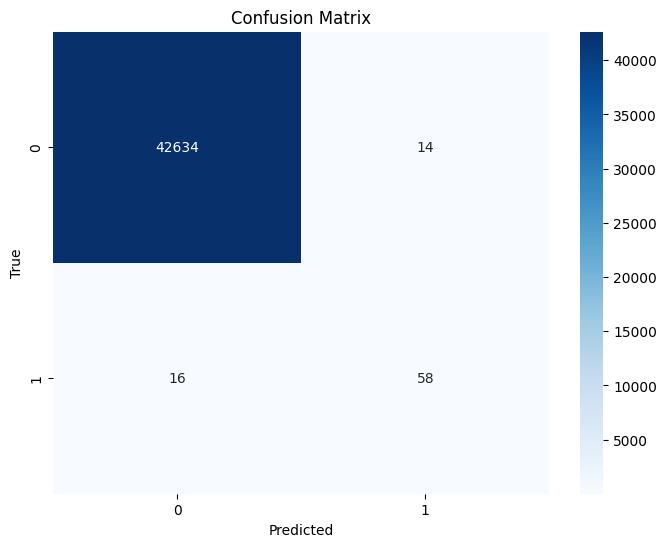

Matthews Correlation Coefficient (MCC): 0.7307
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42647
           1       0.75      0.72      0.73        74

    accuracy                           1.00     42721
   macro avg       0.87      0.86      0.87     42721
weighted avg       1.00      1.00      1.00     42721



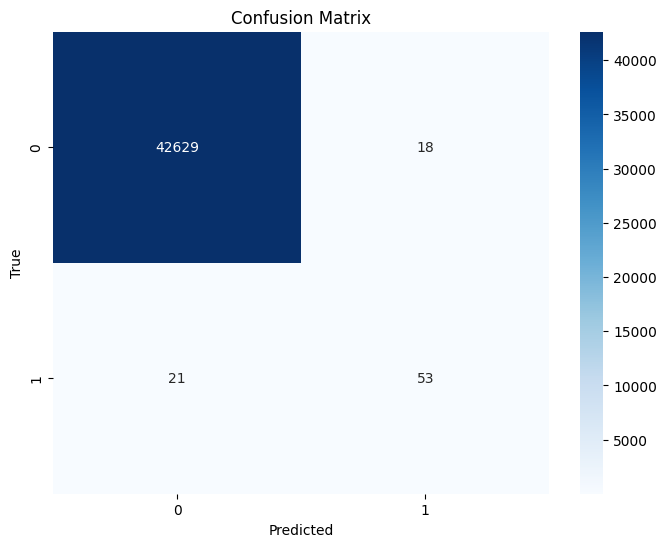

In [179]:
from sklearn.tree import DecisionTreeClassifier

pipeline = Pipeline([
    ('dtc', DecisionTreeClassifier(criterion='gini', class_weight={0: 0.01, 1: 0.99}, random_state=42))
])

pipeline = pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
evaluate(pipeline, X_test, y_test, y_pred)

y_pred = pipeline.predict(X_val)
evaluate(pipeline, X_val, y_val, y_pred)

### Support Vector Machine (SVM)

Matthews Correlation Coefficient (MCC): 0.7807
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42648
           1       0.82      0.74      0.78        74

    accuracy                           1.00     42722
   macro avg       0.91      0.87      0.89     42722
weighted avg       1.00      1.00      1.00     42722



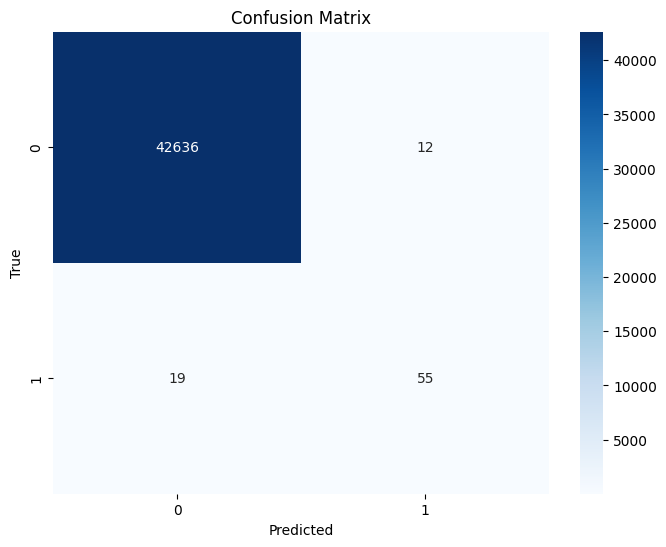

Matthews Correlation Coefficient (MCC): 0.7534
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42647
           1       0.72      0.78      0.75        74

    accuracy                           1.00     42721
   macro avg       0.86      0.89      0.88     42721
weighted avg       1.00      1.00      1.00     42721



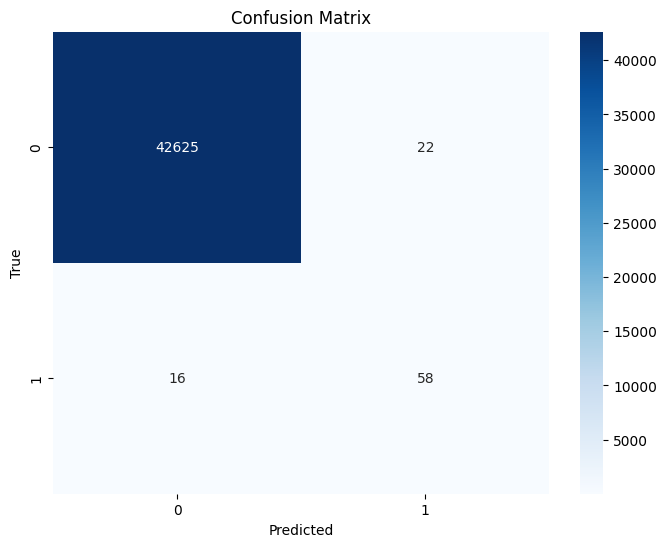

In [180]:
from sklearn.kernel_approximation import Nystroem
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SGDClassifier(loss='log_loss', class_weight={0: 0.1, 1: 0.9}, random_state=42))
])

pipeline = pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
evaluate(pipeline, X_test, y_test, y_pred)

y_pred = pipeline.predict(X_val)
evaluate(pipeline, X_val, y_val, y_pred)

## Summary

The unsupervised anomaly detection models perform surprisingly well compared to supervised models.
Unsurprisingly, the biggest downside of unsupervised models is the false positive rate, which cannot be further reduced without also significantly decreasing the true positives and false negatives.

Generally, the models performed very similar with the exception of the Local Outlier Factor mdeol detecting much fewer false positives than the Isolation Forest.
However, the Isolation Forest model's prediction is somewhat faster, so it could still be of use.